In [1]:

import scipy
import pycbc
import bilby
import pickle
import pycbc.psd
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rcParams.update({"text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 16,
    "axes.formatter.use_mathtext": True,
    "axes.formatter.limits": (-3, 3)
})


In [2]:

delta_f = 1
duration = 100
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048
N_iter = int(1e2)   # Number of iterations of the initial points


def inject_wf(injection_parameters):
    """Generate time domain waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors"""

    waveform_generator = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters['geocent_time']-duration+2,
                                                    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                    waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initializing the Detectors

    for ifo in ifos:
        ifo.minimum_frequency, ifo.maximum_frequency = minimum_frequency, sampling_frequency/2
    ifos.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = injection_parameters['geocent_time']-duration+2)

    # Injecting the SINGLES GW signal into H1, L1, and V1 using bilby and extrapolating the strain data in the time domain

    ifos.inject_signal(waveform_generator = waveform_generator, parameters = injection_parameters)  
    H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain

    # Generating PyCBC TimeSeries from the strain array, setting the start times to the geocenter time, and creating the dictionary of waveforms 

    ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)
    ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = injection_parameters['geocent_time']-duration+2, injection_parameters['geocent_time']-duration+2, injection_parameters['geocent_time']-duration+2
    ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

    return ht


def inject_pairs(injection_parameters_a, injection_parameters_b):
    """Generate time domain PAIRS waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors"""

    waveform_generator_a = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters_a['geocent_time']-duration+2,
                                                     frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                     waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    waveform_generator_b = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters_a['geocent_time']-duration+2,
                                                     frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, 
                                                     waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initializing the Detectors

    for ifo in ifos:
        ifo.minimum_frequency, ifo.maximum_frequency = minimum_frequency, sampling_frequency/2
    ifos.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = injection_parameters_a['geocent_time']-duration+2)

    # Injecting the SINGLES GW signal into H1, L1, and V1 using bilby and extrapolating the strain data in the time domain

    ifos.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # PAIRS (A)
    ifos.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # PAIRS (B)

    H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain

    # Generating PyCBC TimeSeries from the strain array, setting the start times to the geocenter time, and creating the dictionary of waveforms 

    ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)
    ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = injection_parameters_a['geocent_time']-duration+2, injection_parameters_a['geocent_time']-duration+2, injection_parameters_a['geocent_time']-duration+2
    ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

    return ht

In [3]:
waveform_metadata_a, waveform_metadata_b = pickle.load(open('../../src/output/injections/GW Waveform A Meta Data.pkl', 'rb')), pickle.load(open('../../src/output/injections/GW Waveform B Meta Data.pkl', 'rb'))

injection_parameters_a, injection_parameters_b, injection_parameters_c = waveform_metadata_a['H1']['parameters'], waveform_metadata_b['H1']['parameters'], waveform_metadata_a['H1']['parameters'].copy()
injection_parameters_c['geocent_time'] = injection_parameters_b['geocent_time']

In [4]:
injection_parameters_b['geocent_time'] +=0.2
injection_parameters_c['geocent_time'] = injection_parameters_b['geocent_time']

In [5]:
ht_a = inject_wf(injection_parameters_a)
ht_b = inject_wf(injection_parameters_b) 
ht_c = inject_wf(injection_parameters_c) 
ht_ab = inject_pairs(injection_parameters_a, injection_parameters_b)
ht_ac = inject_pairs(injection_parameters_a, injection_parameters_c)

23:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:57 bilby INFO    : Injected signal in H1:
23:57 bilby INFO    :   optimal SNR = 45.48
23:57 bilby INFO    :   matched filter SNR = 45.48+0.00j
23:57 bilby INFO    :   mass_1_source = 34.69993907489076
23:57 bilby INFO    :   mass_ratio = 0.9297253739262261
23:57 bilby INFO    :   mass_1 = 37.671266473449194
23:57 bilby INFO    :   mass_2 = 35.02393230830206
23:57 bilby INFO    :   luminosity_distance = 402.2372317973936
23:57 bilby INFO    :   redshift = 0.08562918200362249
23:57 bilby INFO    :   chi_eff = 0.04987325254489771
23:57 bilby INFO    :   a_1 = 0.5473234710877908
23:57 bilby INFO    :   a_2 = 0.27126319787312464
23:57 bilby INFO    :   tilt_1 = 1.4703452023562735
23:57 bilby INFO    :   tilt_2 = 1.4060762787385255
23:57 bilby I

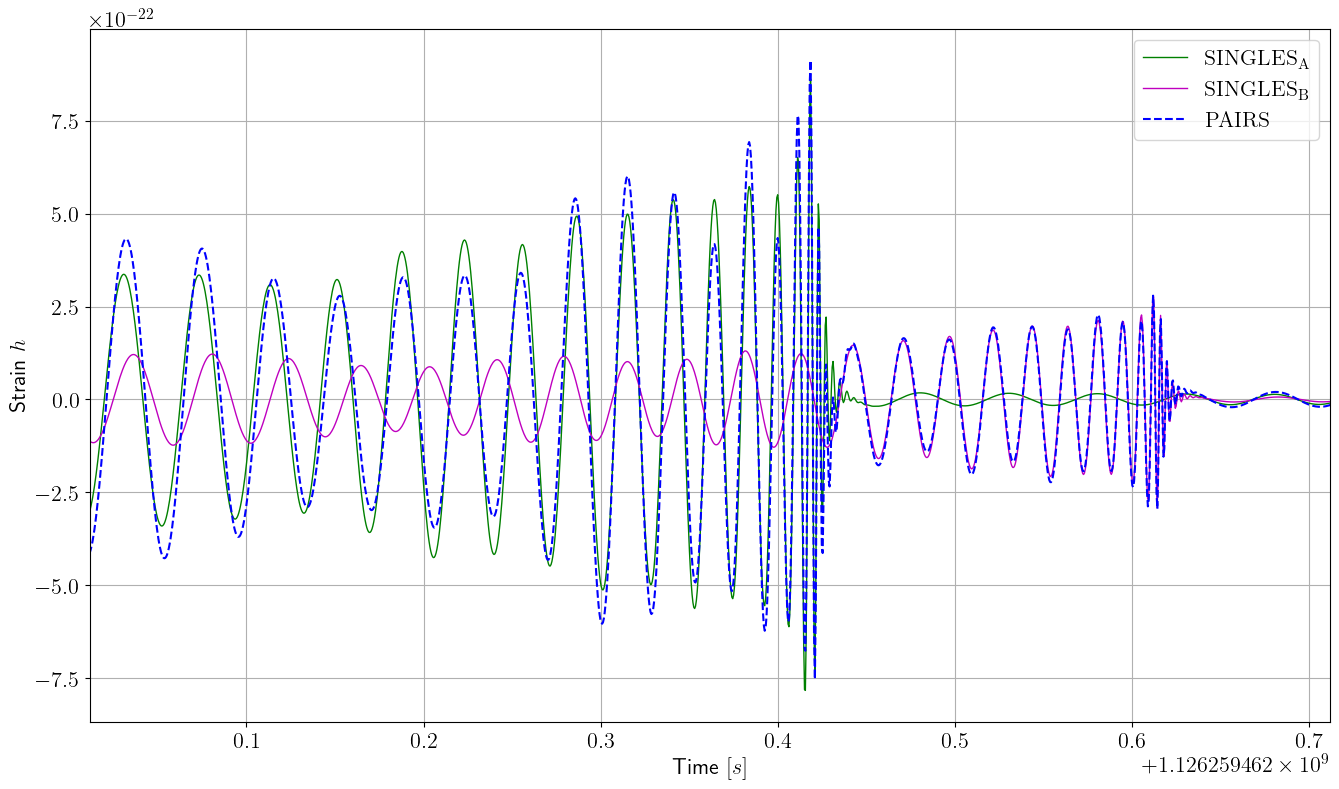

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(ht_a['H1'].sample_times, ht_a['H1'], 'g-', linewidth=1, label='$\\rm{SINGLES_A}$')
ax.plot(ht_b['H1'].sample_times, ht_b['H1'], 'm-', linewidth=1, label='$\\rm{SINGLES_B}$')
ax.plot(ht_ac['H1'].sample_times, ht_ac['H1'], 'b--', label='$\\rm{PAIRS}$')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(start_time+duration-2.4, start_time+duration-1.7)
ax.legend()
ax.grid(True)
plt.savefig('OverlappedSignals2.pdf', format='pdf', bbox_inches="tight")
plt.show()

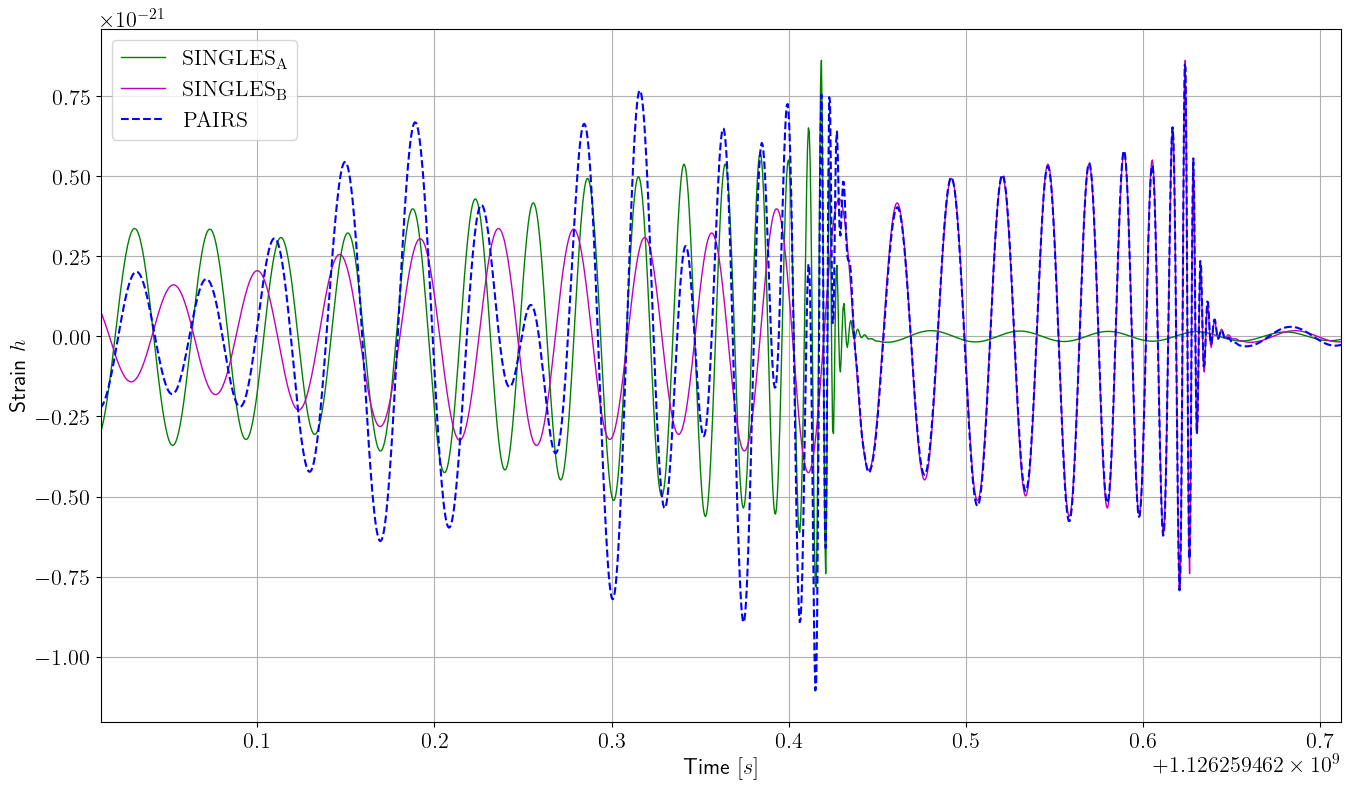

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(ht_a['H1'].sample_times, ht_a['H1'], 'g-', linewidth=1, label='$\\rm{SINGLES_A}$')
ax.plot(ht_c['H1'].sample_times, ht_c['H1'], 'm-', linewidth=1, label='$\\rm{SINGLES_B}$')
ax.plot(ht_ac['H1'].sample_times, ht_ac['H1'], 'b--', label='$\\rm{PAIRS}$')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(start_time+duration-2.4, start_time+duration-1.7)
ax.legend()
ax.grid(True)
plt.savefig('OverlappedSignals2.pdf', format='pdf', bbox_inches="tight")
plt.show()